# Salary Predictor for Jain University MBA Program

Dataset :- available at https://www.kaggle.com/benroshan/factors-affecting-campus-placement, 
Prediction Type :- Regression, 
Evaluation Metric :- Root mean squared error(RMSE)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data cleaning and Visualization

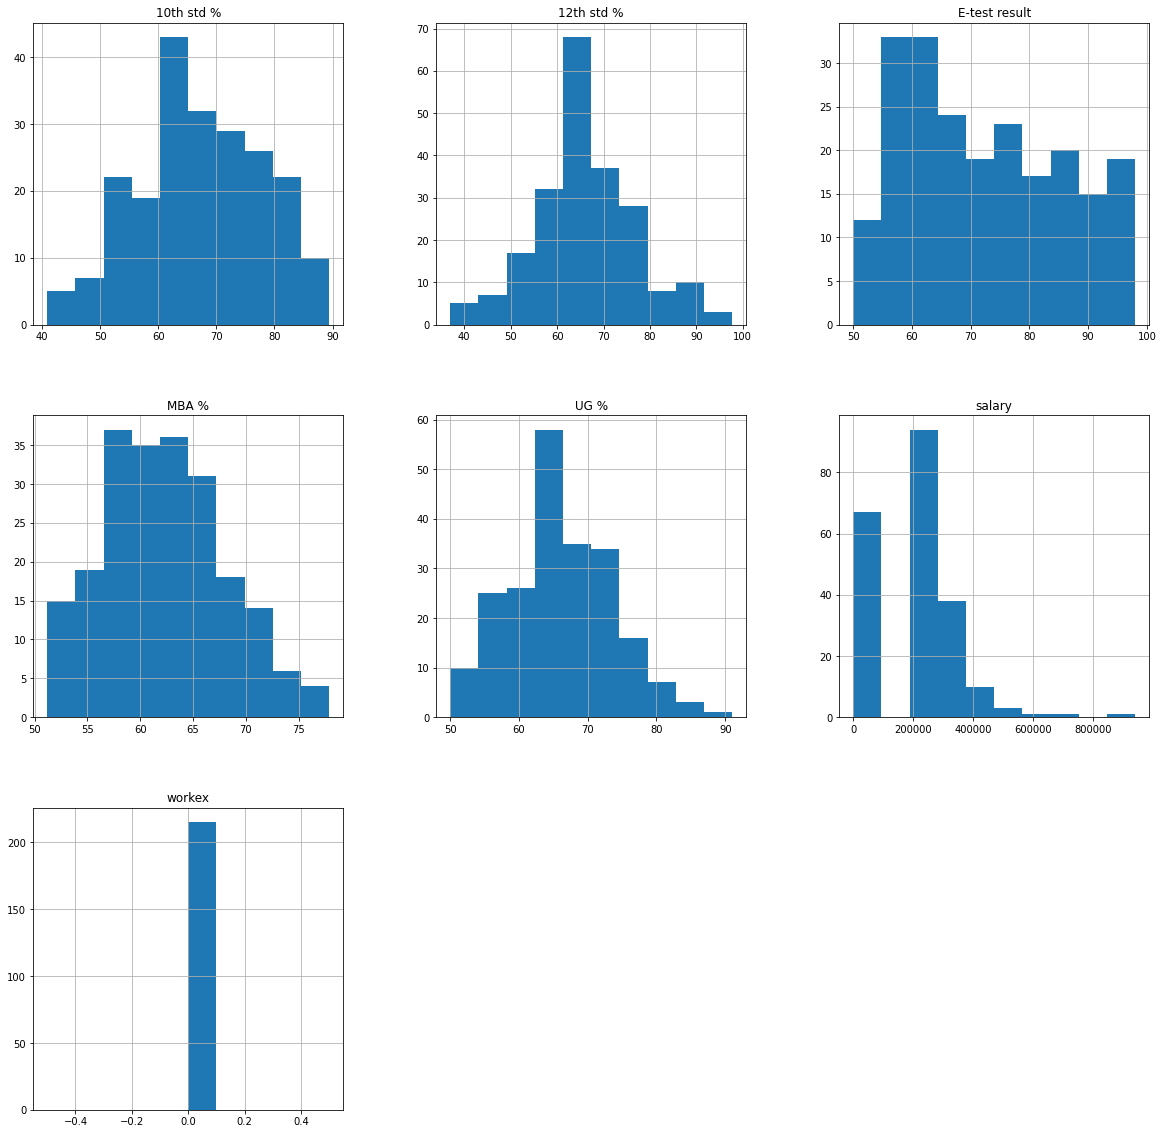

In [3]:
df = pd.read_csv('/home/varun/Downloads/Placement_Data_Full_Class.csv')
df['workex'] = df.workex.eq('yes').mul(1)
df = df.drop(df.columns[[0, 1, 11, 8, 6, 5, 3, 13]], axis=1)
df['salary'] = df['salary'].fillna(0)
df.columns = ['10th std %', '12th std %', 'UG %', 'workex', 'E-test result', 'MBA %','salary']
df.hist(figsize=(20,20))
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   10th std %     215 non-null    float64
 1   12th std %     215 non-null    float64
 2   UG %           215 non-null    float64
 3   workex         215 non-null    int64  
 4   E-test result  215 non-null    float64
 5   MBA %          215 non-null    float64
 6   salary         215 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 11.9 KB


In [5]:
df.describe()

,10th std %,12th std %,UG %,workex,E-test result,MBA %,salary
count,215.000000,215.000000,215.000000,215.0,215.000000,215.000000,215.000000
mean,67.303395,66.333163,66.370186,0.0,72.100558,62.278186,198702.325581
std,10.827205,10.897509,7.358743,0.0,13.275956,5.833385,154780.926716
min,40.890000,37.000000,50.000000,0.0,50.000000,51.210000,0.000000
25%,60.600000,60.900000,61.000000,0.0,60.000000,57.945000,0.000000
50%,67.000000,65.000000,66.000000,0.0,71.000000,62.000000,240000.000000
75%,75.700000,73.000000,72.000000,0.0,83.500000,66.255000,282500.000000
max,89.400000,97.700000,91.000000,0.0,98.000000,77.890000,940000.000000


## Test-Train split and Sampling Approach
Since Employability test is a good indicator of job placement, we will use stratified sampling method to perform a test-train split. For this, we will divide the dataset into sub-groups based on E-test performance. This makes sure that the test set provides a better evaluation and better represents the dataset rather than a completely random test-train split. 

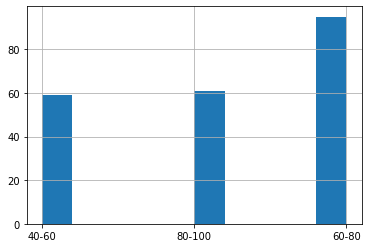

In [6]:
df['E-test group'] = pd.cut(df['E-test result'],bins=[40, 60, 80, 100], labels=['40-60','60-80','80-100'])
df['E-test group'].hist()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state= 42)
for train_index, test_index in split.split(df, df['E-test group']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [8]:
for temp in (train_set, test_set):
    temp.drop(['E-test group','workex'], axis=1,inplace=True)

In [9]:
placement_data = train_set.copy()

In [10]:
corr_matrix = placement_data.corr()
corr_matrix['salary'].sort_values(ascending=False)

salary           1.000000
10th std %       0.544710
12th std %       0.427463
UG %             0.361307
E-test result    0.183695
MBA %            0.135362
Name: salary, dtype: float64

## Regularisation 
For this task we will be using Min-Max Scaling method which scales all values of the dataset between 0 and 1. Since this is a supervised learning task, we will separate the salary labels from the training set.

In [11]:
salary_data = placement_data.drop('salary',1)
salary_labels = placement_data['salary'].copy()

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_train_set = scaler.fit_transform(salary_data)

## Model Training and Selection
We will train three models(Linear Regression, Tree-based Regression and Random Forest Regression). Model selection will be based on RMSE performance through k-folds Cross Valuation.

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(final_train_set, salary_labels)

LinearRegression()

In [14]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(final_train_set, salary_labels)

DecisionTreeRegressor()

In [15]:
from sklearn.ensemble import RandomForestRegressor
rand_forest_reg = RandomForestRegressor()
rand_forest_reg.fit(final_train_set, salary_labels)

RandomForestRegressor()

In [16]:
from sklearn.model_selection import cross_val_score
tree_reg_scores = cross_val_score(tree_reg, final_train_set, salary_labels,scoring = 'neg_mean_squared_error', cv=5)
tree_rmse = np.sqrt(-tree_reg_scores)
lin_reg_scores = cross_val_score(lin_reg, final_train_set, salary_labels,scoring = 'neg_mean_squared_error', cv=5)
lin_reg_rmse = np.sqrt(-lin_reg_scores)
rand_forest_scores = cross_val_score(rand_forest_reg, final_train_set, salary_labels, scoring = 'neg_mean_squared_error', cv=5)
rand_forest_rmse = np.sqrt(-rand_forest_scores)

In [17]:
def display(scores):
    print("scores:", scores)
    print("mean:",scores.mean())
    print("standard deviation:", scores.std())

print('descision_tree performance')
display(tree_rmse)
print('---------------')
print('lin_reg performance')
display(lin_reg_rmse)
print('---------------')
print('ran_forest performance')
display(rand_forest_rmse)
print('---------------')

descision_tree performance
scores: [168840.07136035 162903.8251546  218615.24420772 266112.17089791
 148778.56868514]
mean: 193049.97606114548
standard deviation: 43466.158470528484
---------------
lin_reg performance
scores: [123108.55878172 108752.72865618 116285.20135607 188864.97964521
 106850.6034827 ]
mean: 128772.41438437533
standard deviation: 30595.685182697915
---------------
ran_forest performance
scores: [143443.78720558 126040.1382001  123965.50557262 202694.88285197
 112468.9925046 ]
mean: 141722.66126697365
standard deviation: 32054.98190191974
---------------


## Hyper-parameter Selection
it is clear from the above exercise that Linear Regression performs best having the least mean of 128772.414 out of the three models. Now we use Grid Search to further fine-tune the model and find the best hyper-parameters for our model.

In [18]:
from sklearn.model_selection import GridSearchCV
param_list = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_search = GridSearchCV(lin_reg, param_list, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(final_train_set,salary_labels)
best_model = grid_search.best_estimator_

## Testing
Now, finally after model selection and hyper-parameter tuning, we will test our regression model on the test set and provide a final measure of accuracy. We will perfom the same operations employed on the training set such as separating labels and min-max scaling and provide a final RMSE score obtained by the predictions of our model on the test set.   

In [19]:
X_test = test_set.drop('salary', axis=1)
y_test = test_set['salary'].copy()
final_test_set = scaler.fit_transform(X_test)

In [20]:
from sklearn.metrics import mean_squared_error
final_predict = best_model.predict(final_test_set)
test_scores = mean_squared_error(final_predict, y_test)
test_rmse = np.sqrt(test_scores)
test_rmse

116348.10279143084

In [33]:
new_data = df.iloc[:5].copy()
new_data = new_data.drop(['E-test group','workex','salary'], axis=1)
new_data_scaled = scaler.fit_transform(new_data)
print("prediction:", best_model.predict(new_data_scaled))

prediction: [230608.80635868 274305.88739178 154461.62274646 -44256.92418465
 432791.73473621]


In [34]:
df['salary'].iloc[:5]

0    270000.0
1    200000.0
2    250000.0
3         0.0
4    425000.0
Name: salary, dtype: float64